# Explanation on generator design choices. 

**Don't look if you don't want spoilers!**

This notebook covers the design choices of the [data generator](#Data-generator) (and [changes for the regenerator](#Data-re-generator). If you're looking for an exploratory analysis of the data, look **HERE**. If you're looking for the experimental plan and analysis, look **HERE**.

### Why we need a generator (!) definitely cut this down

**Why I wanted to do this project**

Before I learned to program / decided I wanted to learn to do data science, I ran user-testing programs for hardware products at a tech company. There are a lot of people getting into data science, and while I still feel like a beginner at programming, I'm pretty confident in my business background. So I wanted a project to show that. When I first started, this project had almost nothing to do with business, but it just kind of bled through - the connections were already there.

--> so maybe it's better to just say that? think about the message and try to get it clear.
--> I also like this stuff anyway - ask me about the case study I wrote for a business fraternity in 2018. (I picked this restaurant because I thought the name was funny - I was going to use another restaurant I also wrote a case about called the Himalayan Chimney, but they changed their website to just an ordering screen because of covid, which wasn't as fun).

**Showcasing A/B testing is hard**

Anyway, it's hard to showcase A/B testing because you need a product and users. And every company seems to want A/B testing experience. So instead of giving up, I found a sneaky way around it. When a company does A/B testing, they just look at the data to see how users interact with a change. So instead of actually implementing a change and looking at the data, we can just regenerate data for a month and pretend that's the sales data from the users. It's just order data, so it's not as good as real-time user data (like click-through-rates or stuff like that), but it's not likely most restaurants will have that kind of data either - it's a nice, simple example.

--> also gives us a chance to talk about the difference between a/b testing and other types of user testing
--> don't forget about the pitfalls of A/B testing! How does that apply to this case?

**Notebooks are independent** (!) will probably move to readme

In each workbook, we assume we have no knowledge of other notebooks.

A truer chronological workflow might look like this:

1. Get data
    1. Write generator, generate data [data_generator.py]
    2. Document generator design [generator_explanation.ipynb]
    
    
2. Explore data
    1. Explore, validate data (suggest business recs / potential tests) [data_analysis.ipynb]
    
    
3. Design test
    1. Design experiment for accepted tests [experiment_analysis.ipynb]
    
    
4. Implement test
    1. Regenerate data for test [data_generator.py]
    2. Document re-generator design [generator_explanation.ipynb]
    
    
5. Evaluate findings
    1. Analyze experiment, explain findings [experiment_analysis.ipynb]

# (!) consider removing

# How the generator works

generater calculates orders per hour based on maximum possible orders * occupancy multiplier from popular hours. then it creates a monthly csv based on those. (!) ref: pop hours

there are yearly and monthly multipliers

it also takes the number of years and months, and menu data with weights. and popular hours with weights

output is a csv file for every selected month with five columns


In [1]:
### explain by columns

# Setup

Essentially the same setup that happens in the analysis - we need this to validate our generator later.

In [2]:
import pandas as pd
pd.options.display.max_rows = 10  # limit huge ouputs
import os
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')  # plt.style.available
import pprint
pp = pprint.PrettyPrinter(indent=4)  # make printed dictionaries readable

import warnings
warnings.filterwarnings("ignore")  # filter warnings

In [3]:
df = pd.read_csv("../thaitanic/data/all_data.csv").sort_values(by='Order Date', ascending=False)
df.reset_index(drop=True, inplace=True)
df

,Order ID,Item,Quantity Ordered,Price Each,Order Date
0,314272,Red Curry,1,12,2019-12-31 20:59:00
1,314305,Thai Fried Rice,1,12,2019-12-31 20:55:00
2,314297,Yellow Curry,1,12,2019-12-31 20:55:00
3,314261,Pad Thai,1,12,2019-12-31 20:54:00
4,314288,Tom Yum Gai,2,12,2019-12-31 20:53:00
...,...,...,...,...,...
326935,3919,Tom Kha Gai,2,12,2017-01-01 12:04:00
326936,3951,Pad See Ew,1,12,2017-01-01 12:02:00
326937,3940,Red Curry,2,12,2017-01-01 12:02:00
326938,3913,Pumpkin Curry,1,15,2017-01-01 12:02:00


In [4]:
# add sales, datetime columns to filter by

df['Order Date'] = pd.to_datetime(df['Order Date'])

df['Sales'] = df['Quantity Ordered'] * df['Price Each']

df['Year'] = df['Order Date'].dt.year

df['Month'] = df['Order Date'].dt.month

df['Weekday'] = df['Order Date'].dt.day_name()

df['Weekday Value'] = df['Order Date'].dt.weekday

df['Hour'] = df['Order Date'].dt.hour

df['Day of Month'] = df['Order Date'].dt.day

# Data generator

The generator takes occupancy weights, menu item weights, and date weights and generates monthly csvs.

### (!) Maybe I should focus on explaining what the generator does first, and then explain why it's reasonable afterwards.

### Conceptual revenue model

We don't have ThaiTanic's actual data, but we can can get pretty close by paying attention to public information about their business. Let's consider a revenue model for the restaurant.

![](..\thaitanic/revenue_model.jpg)

Their revenue is basically the number of orders times the cost per order. There's a bunch of stuff that affects those two factors, so we'll look at them one at a time:

1. How many orders does the restaurant get per month?
2. What do people spend on orders?

==> the generator uses information from these assumptions and adds random variance to create the dataset

We can answer the first through market sizing, and the second by making our best guess based on what's on their menu (I asked some friends for input too!). And then we'll add some random variation to the values.

--> can probably move this to the individual sections

# 1. How many orders does the restaurant get per month?

### Market sizing

We want to find out the maximum amount of orders the restaurant could get. We can get this by multiplying the restaurant's max capacity by the number of orders the resturant can handle (which is the average meal length).

##### Restaurant capacity

Based on photos from 
[Yelp](https://www.yelp.com/biz_photos/thaitanic-streetfood-sausalito-2)
and 
[Google](https://www.google.com/maps/uv?pb=!1s0x80858451b4f18a91:0xa561eb4585721e9d!3m1!7e115!4s)
(can't rehost images due to copyright), it looks like there are **30 seats total** (20 indoor, 10 outdoor).

##### # of servable meals + takeout

Google indicates the average time spent per meal is 15 minutes to an hour. One hour seems high for an average, and 30 minutes seems low, but to account for takeout, we can just use 30 minutes. 

The restaurant is open for 8 hours a day, so we're saying they can serve at max 16 meals per seat per day. Our implication is that they can serve (30 * 16 =) **480 meals per day**. This sounds high, but it's really the amount of meals the restaurant would be able to fulfill if they had lines out the door from the minute they open to the minute they close. This assumes space is the limiting factor, not kitchen capacity. 

In the actual data, we probably wouldn't want to see any numbers above 400 except for the busiest days of the busiest months.

For reference...?

### Estimating actual demand

Google also provides "Popular Times" estimates. It doesn't come with a set metric, but we can evaluate it. The thing to note is that the difference between the days is HUGE. The busiest day is almost three times as busy as the least busy day. Google indicates there are practically empty times for most days, which I don't think is totally true. I think it's giving relative values. So I added a buffer: if you look at popular values, I assume we start at 50, and that each tick is 25. Then I divide by 100 to turn it into a multiplier. A formula is as follows:

$f(x) = \frac{25x + 50}{100}$

The values I pulled are specific to 2020 so there's a chance they're uncharacteristically low, but I checked against restaurants in areas not heavily affected by covid and they seemed similar enough to just keep.

***

If we didn't have Google's data, we could just estimate by the hour, or generate data on a per-day basis (which I'm glad we didn't do because that would be much to uniform).

We might also be able to increase accuracy by evaluating the local population, but at that point I would rather sit outside with a clipboard.

In [5]:
# example of weight calculation on the most busy, least busy days of the week

def calculate_hourly_weights(weight):
    """
    takes an occupancy weight from popular_times and returns a multiplier.
    base occupancy is 50. ex: one popular_times bar filled = 75% occupancy.
    """
    return (50 + 25 * weight) / 100

wednesday_hours = {  # least busy day
    # hour value: [hour weight]
    11: [0.25],
    12: [0.5],
    13: [0.5],
    14: [0.5],
    17: [0.75],
    18: [1],
    19: [1],
    20: [0.75],
}

saturday_hours = {  # most busy day
    # hour value: [hour weight]
    12: [1.5],
    13: [2.25],
    14: [2.25],
    15: [1.75],
    17: [2.25],
    18: [2.75],
    19: [2.5],
    20: [1.5],
}

hours_for_day_of_week = { 
    # weekday_value: day_hours dictionary
#     1: tuesday_hours,
    2: wednesday_hours,
#     3: thursday_hours,
#     4: friday_hours,
    5: saturday_hours,
#     6: sunday_hours
}


# add percent_occupancy to day_hours dictionaries
for day in hours_for_day_of_week.values():
    for hour in day:
        day[hour].append(calculate_hourly_weights(day.get(hour)[0]))

print('Wednesday Hours: [base weight, calculated weight]')
pp.pprint(wednesday_hours)
print()
print('Saturday Hours: [base weight, calculated weight]')
pp.pprint(saturday_hours)

Wednesday Hours: [base weight, calculated weight]
{   11: [0.25, 0.5625],
    12: [0.5, 0.625],
    13: [0.5, 0.625],
    14: [0.5, 0.625],
    17: [0.75, 0.6875],
    18: [1, 0.75],
    19: [1, 0.75],
    20: [0.75, 0.6875]}

Saturday Hours: [base weight, calculated weight]
{   12: [1.5, 0.875],
    13: [2.25, 1.0625],
    14: [2.25, 1.0625],
    15: [1.75, 0.9375],
    17: [2.25, 1.0625],
    18: [2.75, 1.1875],
    19: [2.5, 1.125],
    20: [1.5, 0.875]}


We can see that really busy days go over max capacity, which is fine. And not-busy days are esssentially estimated to be half occupancy, which is 240 orders... We want the really busy days to be around 100. It adds some smoothing, because when Google says something is practically no occupancy, it seems way too low.

It feels a bit flawed because in a day where they have 0 capacity all day, the assumption is they still got 240 orders.

The formula was just based on interpreting the popular times chart. Here's an example:

**Wednesday**

![](..\data/popular_times/wednesday.PNG)


**Saturday**

![](..\data/popular_times/saturday.PNG)

I interpret the lowest line to be 50% occupancy. It sounds genereous, but the difference is still pretty big.

So if a line reaches the first light grey tick from the bottom, that's 75% occupancy. And the next is 100%. Based on this, a restaurant can go OVER 100% occupancy, but I don't think that's unreasonable - there would just be a line during that hour.

##### Annual, seasonal weights

I also added weights to decrease the number of orders. Annually, I just wanted the restaurant to be trending upwards. I checked some google market research for this.

I wanted the holiday months to be really high, and the summer months to be slightly higher. The rest ofthe months could be whatever, I put them at 80 (so at 50% occupancy all day - zero bars - we're now looking at about 190 orders. It works out pretty well to start from a high amount and use decreasing multipliers.



### Calculating the number of orders

Based on this information, we calculate order by multiplying the year weight, month weight and... **?**

# Order sizing (probably goes at end... right?)

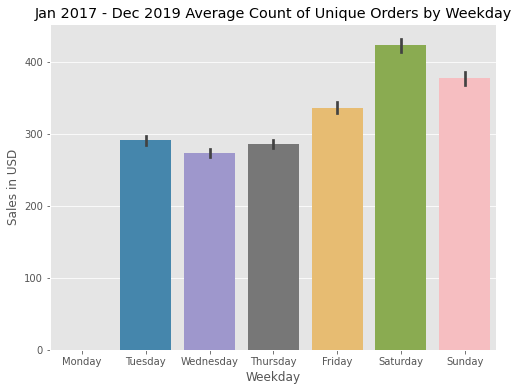

In [6]:
# show average count of unique orders per weekday

weekday_sales_without_monday = orders_per_day = df.groupby(['Year', 'Month', 'Day of Month', 'Weekday Value', 'Weekday']
                                                          ).nunique().reset_index()
weekday_sales_without_monday = weekday_sales_without_monday.sort_values(by='Weekday Value')  # keep weekday order

weekday_sales = pd.DataFrame(columns=weekday_sales_without_monday.columns)
monday_row = {'Weekday': 'Monday', 'Sales': 0}  # show mondays are closed

weekday_sales = weekday_sales.append(monday_row, ignore_index=True)
weekday_sales = pd.concat([weekday_sales, weekday_sales_without_monday]).reset_index(drop=True)

plt.figure(figsize=(8,6))
ax = sns.barplot(data=weekday_sales, x='Weekday', y='Order ID')

# ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')  # rotate if small figsize
plt.title("Jan 2017 - Dec 2019 Average Count of Unique Orders by Weekday")
plt.ylabel("Sales in USD");

this is what we were expecting - 330 is the maximum amount of orders the restaurant could serve in a day. If they had nonstop demand (lines out the door) all day, they would be looking at 330 orders. We see that they get close to this on weekends, but aren't close on weekdays. This is intentional - it looks like the difference in demand is big, but if we didn't add buffer values to the popular times weights, the difference would be even bigger.

For reference, the actual Saturday popular times values are almost three times bigger than Wednesdays!

In [7]:
print(480 * 25)  # >>> 7920 orders per month - abs max

df.groupby(['Year', 'Month']).nunique().reset_index().iloc[:, 0:3].rename(
    columns={'Order ID': 'Count of Unique Orders per Month'}
)

12000


,Year,Month,Count of Unique Orders per Month
0,2017,1,7829
1,2017,2,7102
2,2017,3,7903
3,2017,4,7810
4,2017,5,7651
...,...,...,...
31,2019,8,9416
32,2019,9,7711
33,2019,10,8070
34,2019,11,10881


another double check - we would expect about 8000 orders per month if they were at max capacity every day of the week for a month. But they're not so we see around half of that. it gets close on the busiest months of the year, which is a good sign.

again, it seems like a big difference, but the variation is actually just that big.

### Popular times (by hour)

Used Google popular times to estimate orders per hour. Assigned weights and assumed 0 value gives 50%.

Huge variance - busiest day is almost 3x as busy as least busy day.

---

I noticed Google has "popular_times" values for the restaurant. There isn't really a scale, but I can use these to approximate restaurant occupancy to the hour instead of to the day.

I'm not sure how specific these are to 2020 - they seem a little low to me, but I figured it's fine because I'm just estimating and I'll throw in variance anyway.

##### (!) should I add in variance in the years? and the months?! how did i miss that?

##### (!) add in a visualization that shows the min/max values vs. the average weighted values we have? that would be a cool graph! (would belong in this notebook).

### Annual/seasonal multipliers

Year multiplier, summer/winter month multiplier. Mostly negative.

### Chance for additional item in order

If ordering starter or dessert, there's a chance for an additional item. 

### Chance for increased order quantity

### Generating by hour

Tried by month (because csvs are by month), but "accuracy" to the hour made more sense. Added variance with normal distribution.

### Weights for menu (by category, by item)

Categories have weights, and then within the category the items have weights.

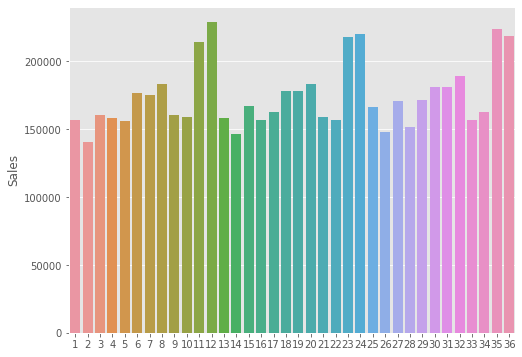

In [8]:
# look at actual month sales - maybe i should add this after the order validation?

month_sales = df.groupby(['Year', 'Month']).sum().reset_index()
month_sales.index += 1

plt.figure(figsize=(8,6))  # figsize not applying for some reason
ax = sns.barplot(x=month_sales.index, y=month_sales['Sales'])

This helps us size the total market. The idea is that we can estimate the total realistic output from the restaurant, and then apply modifiers to decrease from there. 

# 2. What do people spend on orders?

I peeked at yelp too for input and considered scraping them for ratings, but their robot.txt disallows it.

This part was really easy... I just added in the weights from the menu. 

### Menu weights

I copied the menu and added weights per category and then per item. The category weights were basd on whether or not I thought someone would want an item from there if they actually ordered. It also had to do with how good the items were. 

Then for the items in the category, there are relative weights that determine which item should be preferred once the category is selected.

I peeked at the local population and went with my gut on what I thought would actually be ordered (it hurt me to rank Pad Thai above Pad See Ew). I also asked some friends for input on this. I initially considered asking a bunch of people on the internet to tell me what they would actually order, but I figured it was overkill (might be fun for another project though).

### Order quantity 

I kind of just added this in at the end, but it felt like the values were really low so I threw in a chance to order more of an item.

And also a chance to order a second item. Both of these increase total quantity ordered and therefore sales, but I think it's fine.

### Adding a second item to an order

There's a small chance to order a second item. It's really high if it's a dessert, and it's kind of high if there's an appetizer. I actually forgot about the appetizer part, then rediscovered it in the analysis.

# Talk about the distributions!

Will take a break to work on the generator but will be back!

Updated scale from 40 to 60, loc from 5 to 10. **This is based on the market sizing!** The scale is what we put into the random normal distribution, and then multiply that by the weights. 

What amount am I expecting? 

In [9]:
60 * 8 * 0.8 * 0.985 * 0.80 * 26# doesn't count hour weight (between 0.5 and 0.7 mostly)

# do i need to think more about the scale? it just means the 60 could be any number from 50 to 70, which is reasonable.
# the diff. is kind of big, but i guess there's a lot of variation in restaurants?

7867.392000000001

(?) Why did it print 8000... obviously because i printed the entire month. Seems high though...

In [10]:
t = pd.read_csv('..\generator/January_2017_data.csv')
t.groupby('Quantity Ordered').count()

FileNotFoundError: [Errno 2] No such file or directory: '..\\generator/January_2017_data.csv'

In [ ]:
import numpy as np
import math

quantity_ordered = []

# test = round(np.random.exponential(scale=1.0, size=1)[0],0)
for quantity in range(100):
    value = math.ceil(np.random.exponential(scale=1, size=100)[0])
    quantity_ordered.append(value)

sns.displot(data=quantity_ordered);

We use a random exponential distribution on quantity ordered because most people should order one or two things, and then it should drop off a lot after that. It's okay if there are occasional orders of a weirdly large amount of stuff, maybe it's catering or a group buying or something.

# Improvements

- Order IDs don't match Order Date. They're all within the hour, but they're random. It doesn't really make sense that the first order would be 10 minutes from closing, while the next order after that is halfway through the shift. The solution is probably to generate from a minute basis, but it seems like a small enough detail to skip for now. **I think this is the only real flaw in the data** - the rest are just minor inaccuracies.
- Code is a bit slow. There are some list comprehensions in the loop that aren't very elegant because I was accessing multi-element lists in a dictionary. It felt like too much to explicitly get lists of the weight element from the dictionary, so I put it in the loop. I'm sure there's also a cleaner way I could've added options for additional orders, but will revisit when I have a deeper understanding of programming.
- I think my usage of nested loops is appropriate here, but wow it's ugly to see that many nested loops. I'm sure I'll realize a better way to have built that in the future.
- This applies to all of the notebooks in this project, but I think they get messy when there's too much content, and I'm a bit verbose. I'll work on it.
- I used an exponential distribution on quantity ordered which isn't wrong, but it feels too uniformly exponential. I would imagine most orders to be one, then two through four, then some ives and sixes, then almost nothing, then a bunch of orders from corporate catering around 10. Instead, it follows a smooth exponential curve which is a bit too pretty.
- I calculated the orders based on a single person, and changed the quantity ordered to an exponential distribution without checking how that affects the total quantity ordered. The data is a bit conservative, but the orders and therefore sales are bit higher than I intended. But it's a family style place so it's not too bad. 

If you're reading this and have advice for any of the above (or any feedback on the project at all, really!) please let me know. Pull requests or emails work.

# Data re-generator

I'm going to talk about regenerating data for the A/B test now. Chronologically, this takes place AFTER the analysis and writing out the experiment. If you want to read those first, the links are here:

We regenerate fresh data to simulate collection of user data. 

Current plan is slight random variance in weights, and printing out the weight used to a .txt file which I won't look at until after the analysis. The goal is to evaluate whether or not the value went up or down, and whether it's statistically significant or just noise (e.g. the change we made actually had some impact). 

I'll look at the randomly printed value afterwards to compare. Might make a note: based on the test results, I would say this is statistically significant and would recommend this change going forward. Bonus: since it's a simulation, I'll try to guess the weight (not really sure if this is worth anything since there's so many random variation all over the place, but it's just for fun).

# Other notes

I did 2017 - 2019 data because I didn't want to touch covid in this dataset. The effects are complicated enough that mocking data doesn't seem to be the best fit (if you really wanted to, you could use machine learning to emulate datasets instead).


### NOTE: don't be so explicit! no need to explain everything you did, just talk about what you did and if it's complicated you can also say why. It's documentation, not a lecture...